# **CHALLENGE IMA 205**
## **CLASSIFICATION OF DERMOSCOPIC IMAGES**
### **Segmentation notebook**
## Samia ABRIK

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

## Loading train images and their corresponding masks

In [2]:
train_images = []
images_path = 'ima205-challenge-2024/Train_imgs_masks_separated/images'
for img in sorted(os.listdir(images_path)):  
    image_path = os.path.join(images_path, img)
    image = plt.imread(image_path)
    image = cv2.resize(image, (256, 192)) # Resize images to (256, 192)
    train_images.append(image)
train_images = np.array(train_images).astype('float32') / 255.0 # Normalize images
print('Number of train images :', len(train_images))
    
train_masks = []
masks_path = 'ima205-challenge-2024/Train/Train'
for mask in sorted(os.listdir(masks_path)): 
    if mask.endswith('_seg.png'):
        mask_path = os.path.join(masks_path, mask)
        mask = plt.imread(mask_path)
        mask = cv2.resize(mask, (256, 192)) # Resize masks to (256, 192)
        train_masks.append(mask)
train_masks = np.array(train_masks).astype('float32') / 255.0
train_masks = np.expand_dims(train_masks, axis=-1)  # Add channel dimension for masks
print('Number of train masks :', len(train_masks))

Number of train images : 1945
Number of train masks : 1945


In [3]:
# Check images and masks shape
print(train_images[83].shape)
print(train_masks[83].shape)

(192, 256, 3)
(192, 256, 1)


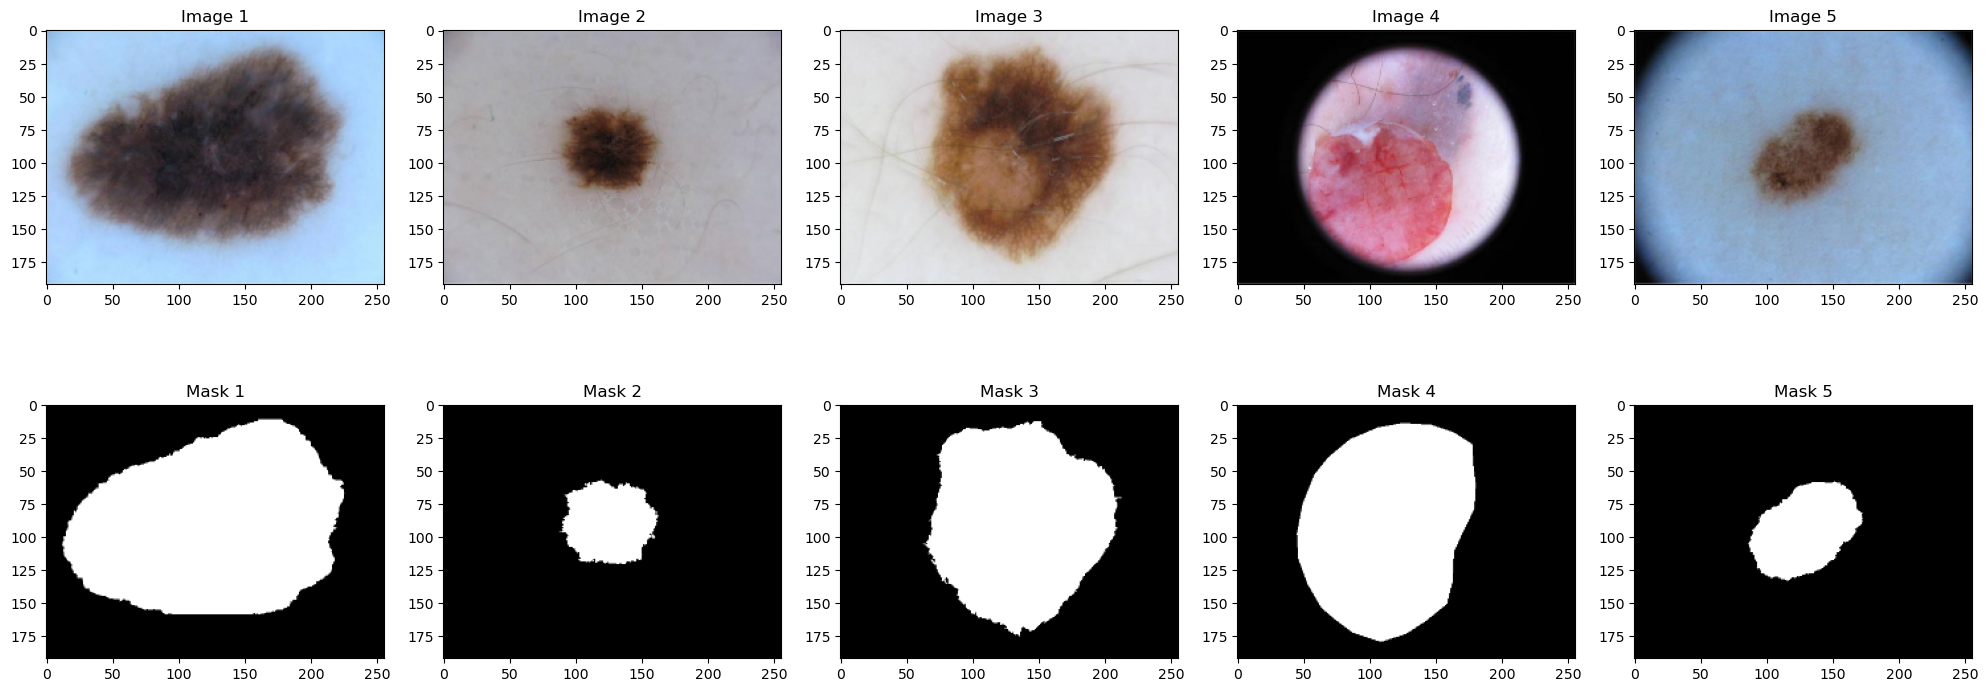

In [4]:
# Plotting the images with their corresponding masks
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(5): 
    axs[0, i].imshow(train_images[i])
    axs[0, i].set_title(f'Image {i+1}') 

    axs[1, i].imshow(train_masks[i], cmap='gray') 
    axs[1, i].set_title(f'Mask {i+1}')  

plt.tight_layout()  
plt.show()

## Build the U-Net model for segmentation

In [19]:
def unet_model(input_size=(192, 256, 3)):
    inputs = Input(input_size, name='input_layer')

    # Contracting Path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(inputs)
    c1 = BatchNormalization(name='bn1_1')(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2')(c1)
    c1 = BatchNormalization(name='bn1_2')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1')(p1)
    c2 = BatchNormalization(name='bn2_1')(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2')(c2)
    c2 = BatchNormalization(name='bn2_2')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(p2)
    c3 = BatchNormalization(name='bn3_1')(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(c3)
    c3 = BatchNormalization(name='bn3_2')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1')(p3)
    c4 = BatchNormalization(name='bn4_1')(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2')(c4)
    c4 = BatchNormalization(name='bn4_2')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same', name='bottleneck_conv1')(p4)
    c5 = BatchNormalization(name='bn5_1')(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same', name='bottleneck_conv2')(c5)
    c5 = BatchNormalization(name='bn5_2')(c5)

    # Expanding Path
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', name='upconv6')(c5)
    u6 = Concatenate(name='concat6')([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv6_1')(u6)
    c6 = BatchNormalization(name='bn6_1')(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv6_2')(c6)
    c6 = BatchNormalization(name='bn6_2')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='upconv7')(c6)
    u7 = Concatenate(name='concat7')([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv7_1')(u7)
    c7 = BatchNormalization(name='bn7_1')(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv7_2')(c7)
    c7 = BatchNormalization(name='bn7_2')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='upconv8')(c7)
    u8 = Concatenate(name='concat8')([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv8_1')(u8)
    c8 = BatchNormalization(name='bn8_1')(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv8_2')(c8)
    c8 = BatchNormalization(name='bn8_2')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='upconv9')(c8)
    u9 = Concatenate(name='concat9')([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv9_1')(u9)
    c9 = BatchNormalization(name='bn9_1')(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv9_2')(c9)
    c9 = BatchNormalization(name='bn9_2')(c9)

    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid', name='output_layer')(c9)

    model = Model(inputs, outputs, name='U-Net')
    return model

In [21]:
# Create U-Net model
unet = unet_model()
unet.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_1 (Conv2D)               (None, 192, 256, 64  1792        ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 bn1_1 (BatchNormalization)     (None, 192, 256, 64  256         ['conv1_1[0][0]']                
                                )                                                             

In [22]:
with tf.device('/gpu:0'):
    # Compile the model
    unet.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = unet.fit(
        train_images, 
        train_masks, 
        batch_size=16, 
        epochs=70, 
        verbose=1,
    )

Epoch 1/70
122/122 [==============================] - 65s 449ms/step - loss: 0.4138 - accuracy: 0.7377
Epoch 2/70
122/122 [==============================] - 46s 375ms/step - loss: 0.0804 - accuracy: 0.7835
Epoch 3/70
122/122 [==============================] - 46s 374ms/step - loss: 0.0253 - accuracy: 0.7835
Epoch 4/70
122/122 [==============================] - 46s 373ms/step - loss: 0.0141 - accuracy: 0.7835
Epoch 5/70
122/122 [==============================] - 46s 374ms/step - loss: 0.0103 - accuracy: 0.7835
Epoch 6/70
122/122 [==============================] - 46s 375ms/step - loss: 0.0086 - accuracy: 0.7835
Epoch 7/70
122/122 [==============================] - 46s 374ms/step - loss: 0.0077 - accuracy: 0.7835
Epoch 8/70
122/122 [==============================] - 46s 375ms/step - loss: 0.0072 - accuracy: 0.7835
Epoch 9/70
122/122 [==============================] - 46s 374ms/step - loss: 0.0068 - accuracy: 0.7835
Epoch 10/70
122/122 [==============================] - 46s 374ms/step - l

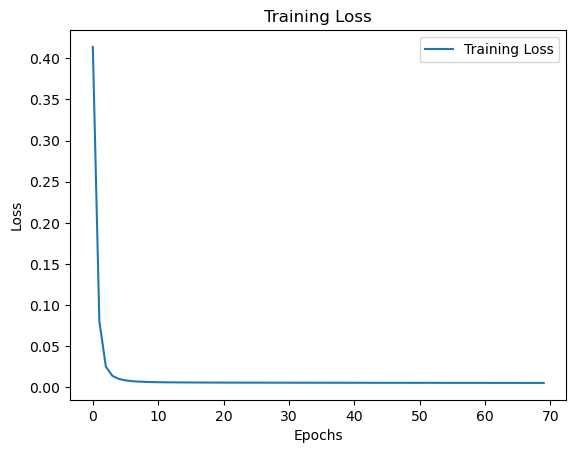

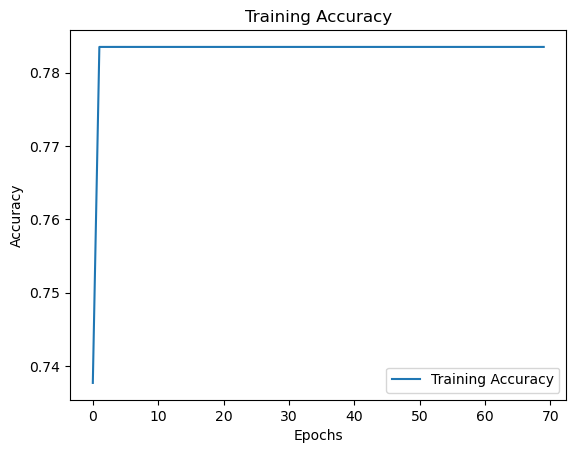

In [23]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss') 
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Predict masks

In [24]:
def predict_mask(image, model):
    pred_mask = model.predict(np.expand_dims(image, axis=0))[0]  # Add batch dimension and predict  
    pred_mask = pred_mask.reshape((192,256)) # Remove channel dimension
    pred_mask = (pred_mask > 0.001).astype(np.uint8) # Apply threshold
    return pred_mask

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


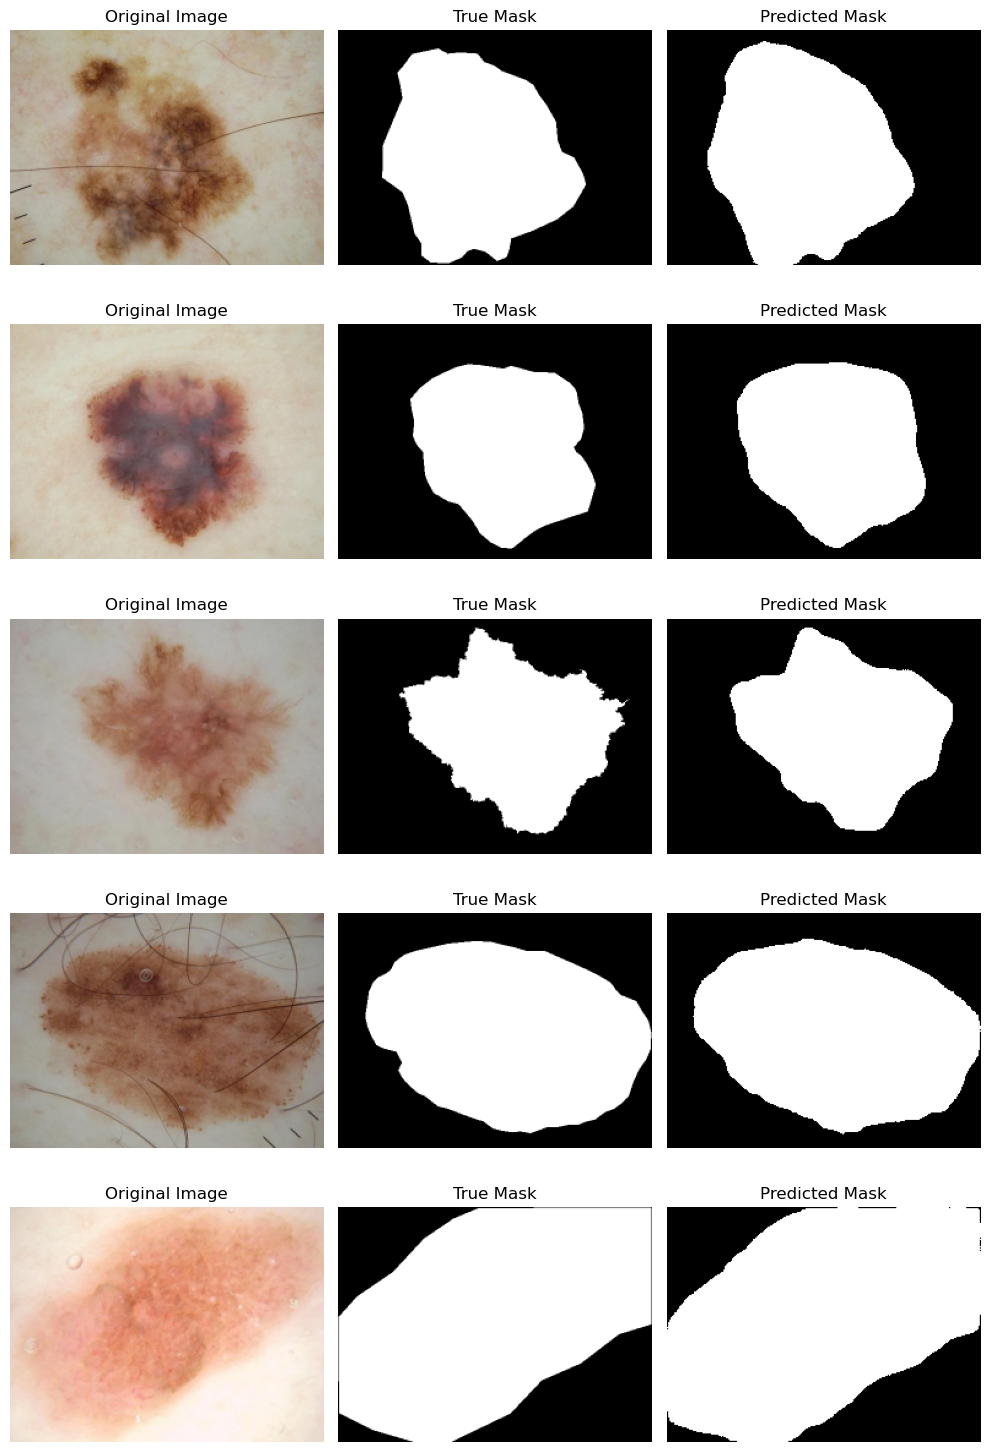

In [27]:
num_images = 5  
c = 738
images_to_display = train_images[c:num_images+c]
masks_to_display = train_masks[c:num_images+c]
predicted_masks = [predict_mask(img,unet) for img in images_to_display]

fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 3))
for i in range(num_images):
    axes[i, 0].imshow(images_to_display[i])  # Original image
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(masks_to_display[i], cmap='gray')  # True mask
    axes[i, 1].set_title('True Mask')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(predicted_masks[i], cmap='gray')  # Predicted mask
    axes[i, 2].set_title('Predicted Mask')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

## Save the model 

We save the model to use it in the second notebook where we perform classification.

In [28]:
# Save the model
unet.save('UNet_model0.h5')